**Filled notebook:**
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/msgtsuzuki/saved_models/blob/main/tutorial2/Tutorial02-N.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/msgtsuzuki/saved_models/blob/main/tutorial2/Tutorial02-N.ipynb)   

#Activation Functions

In this tutorial, a closer examination of (popular) activation functions will be conducted to investigate their impact on optimization properties in neural networks. Activation functions play a crucial role in deep learning models by introducing non-linearity to neural networks. The literature offers a wide range of activation functions, some of which are more advantageous than [others](https://arxiv.org/abs/1710.05941). The objective of this tutorial is to demonstrate the importance of selecting a suitable activation function (and how to accomplish this) and to elucidate the potential issues that may arise if an inappropriate choice is made.
Before starting, standard libraries are imported, and basic functions are set up.

In [ ]:
## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib_inline
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

A function will be defined to set a seed on all libraries that might be interacted with in this tutorial (specifically numpy and torch). This facilitates the reproducibility of the training. However, it should be noted that, unlike the CPU, utilizing the same seed on different GPU architectures may yield different results.

Furthermore, the subsequent cell establishes two paths: `DATASET_PATH` and `CHECKPOINT_PATH`. The path of the dataset denotes the directory in which the datasets utilized in the notebooks will be downloaded. It is advisable to consolidate all PyTorch datasets into a single directory to prevent redundant downloads. However, the path to the checkpoint signifies the directory in which the trained model weights and additional files will be stored. The required files will be automatically downloaded. If using Google Colab, it is suggested to modify the directories to begin from the current directory (i.e. remove `../` from both the dataset and the checkpoint paths).

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial2"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


The following cell downloads all pre-trained models that will be used in this notebook. Files are stored in a separate [repository](https://github.com/msgtsuzuki/saved_models/blob/main) to reduce the size of the notebook repository.

In [ ]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/msgtsuzuki/saved_models/main/tutorial2/"
# Files to download
pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

##Common activation functions

As a first step, common activation functions will be implemented. Although many of these functions are available in the `torch.nn` package (refer to [documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for an overview), custom functions will be written here to improve comprehension and insight.
To facilitate comparison among various activation functions, a base class will be defined from which all future modules will inherit.

In [ ]:
class ActivationFunction(nn.Module):

    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

Each activation function will be implemented as an `nn.Module` to facilitate integration into a network. A `config` dictionary will be utilized to store adjustable parameters for certain activation functions.

Subsequently, two of the "oldest" activation functions still commonly used for various tasks, sigmoid and tanh, will be implemented. While both sigmoid and tanh activations are available as PyTorch functions (`torch.sigmoid`, `torch.tanh`) or modules (`nn.Sigmoid`, `nn.Tanh`), they will be implemented manually here.

In [ ]:
##############################

class Sigmoid(ActivationFunction):

    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

##############################

class Tanh(ActivationFunction):

    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

##############################

Another popular activation function that has facilitated the training of deeper networks is the Rectified Linear Unit (ReLU). Despite its simplicity as a piecewise linear function, ReLU offers a significant advantage over sigmoid and tanh: a strong, stable gradient across a wide range of values. Based on this concept, various variations of ReLU have been proposed, including LeakyReLU, ELU, and Swish.

LeakyReLU substitutes the zero settings in the negative part with a smaller slope to allow gradients to flow in this region of the input. Similarly, ELU replaces the negative part with an exponential decay function. The most recent addition to the family of activation functions is Swish, which emerged from a comprehensive experiment aimed at discovering the "optimal" activation function.
In comparison to other activation functions, Swish is both smooth and non-monotonic, featuring a change in gradient sign. This characteristic has been shown to mitigate the issue of dead neurons inherent in standard ReLU activation, particularly in deep networks. For a more in-depth discussion of the benefits of Swish, refer to [this article](https://arxiv.org/abs/1710.05941).
The implementation of these four activation functions is provided in the following.

In [ ]:
##############################

class ReLU(ActivationFunction):

    def forward(self, x):
        return x * (x > 0).float()

##############################

class LeakyReLU(ActivationFunction):

    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

##############################

class ELU(ActivationFunction):

    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x)-1)

##############################

class Swish(ActivationFunction):

    def forward(self, x):
        return x * torch.sigmoid(x)

##############################

For future reference, all activation functions are consolidated in a dictionary that maps the name to the corresponding class object. If a new activation function is implemented, it should be added to this dictionary to ensure its inclusion in future comparisons.

In [ ]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

#Visualizing activation functions

To gain insight into the behavior of each activation function, they will be visualized in the subsequent section. Alongside the actual activation value, the gradient of the function is a critical aspect, as it plays a crucial role in optimizing the neural network. PyTorch facilitates gradient computation by invoking the `backward` function.

In [ ]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.

    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor.
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"

Now, all activation functions can be visualized, along with their gradients.

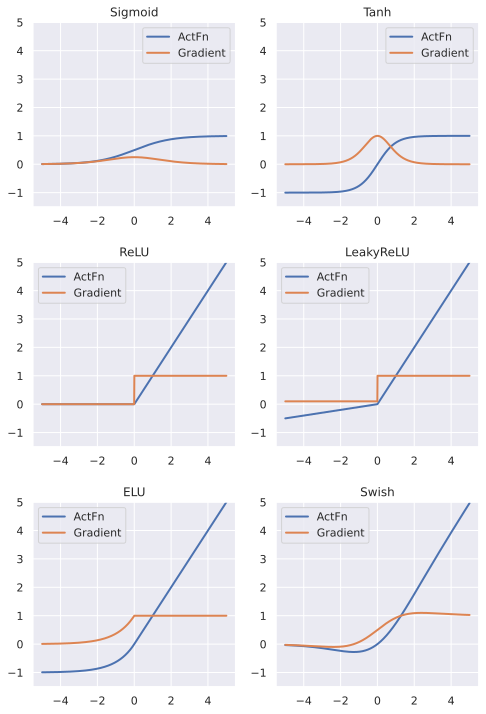

In [ ]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

##Analysing the effect of activation functions

After implementing and visualizing the activation functions, the goal is to gain insight into their effect. This is achieved by using a simple neural network trained on [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) and examining various aspects of the model, including performance and gradient flow.

##Setup

First, a neural network is set up. The chosen network views the images as 1D tensors and pushes them through a sequence of linear layers and a specified activation function. This is a feedforward neural network (FFNN), specifically a multi-layer perceptron (MLP). Users are encouraged to experiment with other network architectures.

In [ ]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes # Define the number of layers

        # Loop through layer to create fully connected layers
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]  # Include the output layer
        self.layers = nn.Sequential(*layers) # nn.Sequential summarizes a list of modules into a single module, applying them in sequence

        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1) # Reshape images to a flat vector
        out = self.layers(x)
        return out

The `BaseNetwork` class inherits from `nn.Module`, which is the base class for all the neural network modules in PyTorch. The network architecture consists of multiple fully connected (linear) layers followed by a specified activation function. The `__init__` method initializes the network architecture based on the specified parameters such as input size, number of classes, and hidden layer sizes.
The `forward` method defines the forward pass of the network, where the input data is passed through the sequence of linear layers and activation functions.
The `nn.Sequential` module is used to sequentially apply the defined layers.
The network can accommodate different activation functions `act_fn` specified by the user, allowing flexibility in the choice of non-linearities.
Overall, this architecture represents a classic FFNN, capable of handling classification tasks with multiple hidden layers and non-linear activations.

Functions for loading and saving the model are also added. The hyperparameters are stored in a configuration file, specifically a simple JSON file.

In [ ]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None):
    """
    Loads a saved model from disk.

    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        net - (Optional) If given, the state dict is loaded into this model. Otherwise, a new model is created.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net

def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.

    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

The dataset selected for training is [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist), a more complex version of MNIST featuring black-and-white images of clothing items instead of digits. FashionMNIST comprises 10 classes, including trousers, coats, shoes, bags, and more. To load this dataset, the `torchvision` package is utilized, another PyTorch package. [`torchvision`](https://pytorch.org/docs/stable/torchvision/index.html) encompasses popular datasets, model architectures, and common image transformations for computer vision tasks. Throughout this course, the package simplifies the handling of the dataset. In the following, the dataset is loaded and several images are visualized to provide an overview of the data.

In [ ]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

100%|██████████| 26421880/26421880 [00:02<00:00, 10075453.76it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 171146.02it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3190560.95it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23267539.86it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



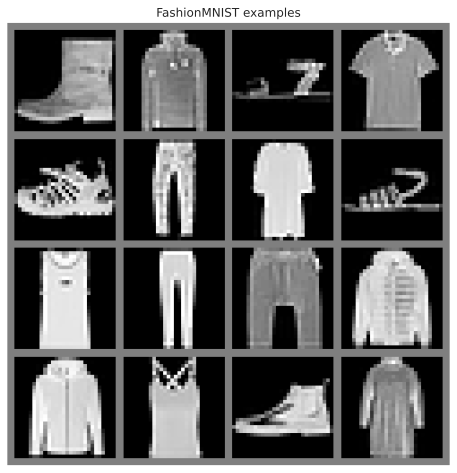

In [ ]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

##Visualizing the gradient flow after initialization

As mentioned previously, an important aspect of activation functions is how they propagate gradients through the network. Consider a scenario in which a very deep neural network comprises more than 50 layers. The gradients for the input layer, representing the initial layer, have passed through the activation function over 50 times, yet it is crucial for them to remain of a reasonable size. If the gradient through the activation function is (on average) significantly smaller than 1, the gradients will diminish as they propagate towards the input layer. On the contrary, if the gradient through the activation function exceeds 1, the gradients will exponentially amplify and might cause explosion issues.

To assess how each activation function influences the gradients, one can examine a freshly initialized network and measure the gradients for each parameter across a batch of 256 images.

In [ ]:
def visualize_gradients(net, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()

    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index%columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

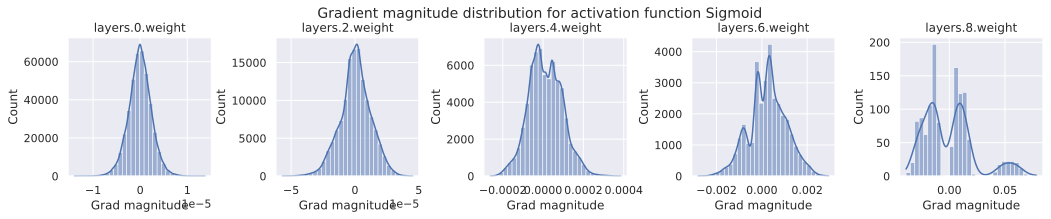

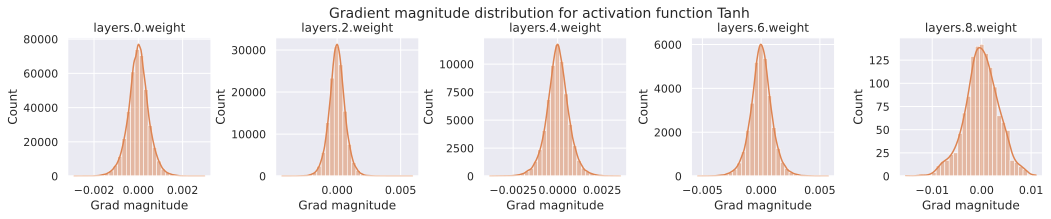

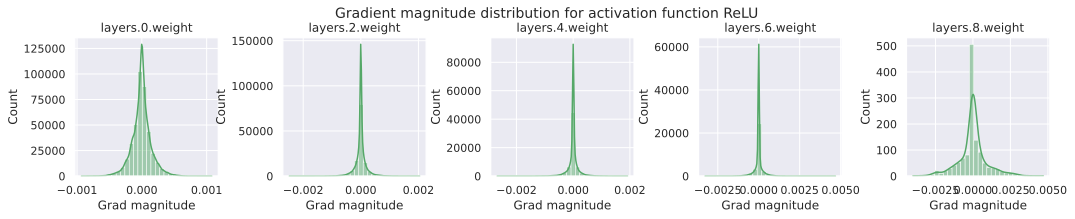

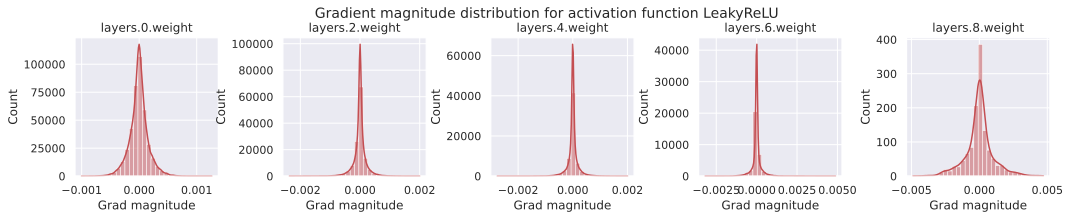

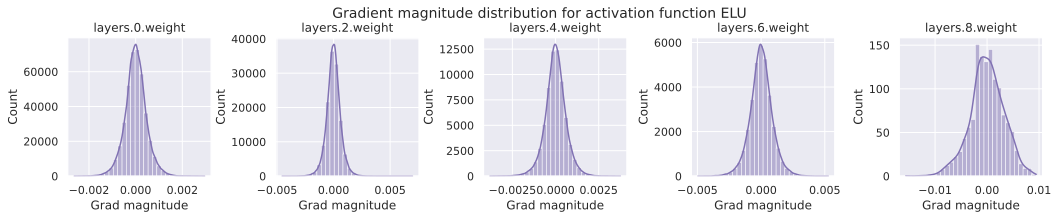

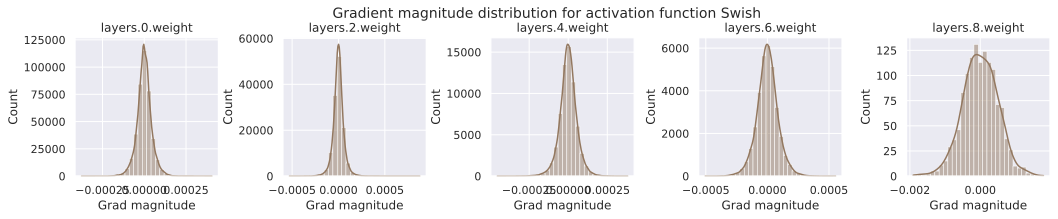

In [ ]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    set_seed(42) # Setting the seed ensures that we have the same weight initialization for each activation function
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")

The sigmoid activation function exhibits undesirable behavior. Although the gradients for the output layer are notably large, reaching up to 0.1, the input layer displays the lowest gradient norm across all activation functions, measuring only $10^{-5}$. This disparity stems from its maximum gradient being limited to 1/4, making it impractical to find a suitable learning rate that accommodates all layers effectively in this configuration.

However, all other activation functions demonstrate similar gradient norms across all layers. Notably, the ReLU activation displays a spike around 0, a consequence of its zero-part on the left, potentially resulting in dead neurons (which will be further examined later).

It is important to note that in addition to activation functions, the initialization of weight parameters can also play a crucial role. By default, PyTorch uses Kaiming initialization for linear layers optimized for [ReLU activations](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_). While initialization will be explored in more detail in Tutorial 3, it is reasonable to assume for now that the Kaiming initialization performs adequately well for all activation functions.

##Training a model

Next, the aim is to train the model with various activation functions on FashionMNIST and evaluate the resulting performance. Ultimately, the objective is to attain the optimal performance on the dataset.

To accomplish this, a training loop is implemented in the subsequent cell, featuring validation after each epoch and a final evaluation on the best model.

In [ ]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Default parameters, feel free to change
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device) # To GPU
                optimizer.zero_grad() # Zero-grad can be placed anywhere before "loss.backward()"
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    return test_acc


def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

One model is trained for each activation function. It is recommended to utilize pre-trained models to expedite the process, particularly if the notebook is running on a CPU. If one wishes to conduct the training and replace the files, the parameter `foverwrite` should be configured as `True`.

In [ ]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)


Training BaseNetwork with sigmoid activation...
Model file already exists. Skipping training...
============= Test accuracy: 10.00% ==============

Training BaseNetwork with tanh activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.09% ==============

Training BaseNetwork with relu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.62% ==============

Training BaseNetwork with leakyrelu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.89% ==============

Training BaseNetwork with elu activation...
Model file already exists. Skipping training...
============= Test accuracy: 87.77% ==============

Training BaseNetwork with swish activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.08% ==============



Not surprisingly, the model employing the sigmoid activation function shows poor performance and fails to surpass random chance (1/10 for 10 classes). On the contrary, models that use other activation functions exhibit similar levels of performance.

To draw a more accurate conclusion, training the models with multiple seeds and examining the averages would be necessary. However, the identification of the "optimal" activation function is influenced by various factors such as hidden sizes, number of layers, type of layers, task, dataset, optimizer, learning rate, etc. Thus, conducting an exhaustive search of the grid would not be practical in this scenario.

In the literature, activation functions that have been successful with deep networks predominantly include various forms of ReLU, as explored in this experiment, with marginal improvements observed for specific activation functions in specific networks.

##Visualizing the activation distribution

After training the models, one can analyze the actual activation values within the model. For example, they can examine how many neurons are set to zero in ReLU and where the majority values lie in Tanh. To address these inquiries, a straightforward function can be written. This function takes a trained model, applies it to a batch of images, and plots the histogram of the activations within the network.

In [ ]:
def visualize_activations(net, color="C0"):
    activations = {}

    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        # We need to manually loop through the layers to save all activations
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()

    ## Plotting
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

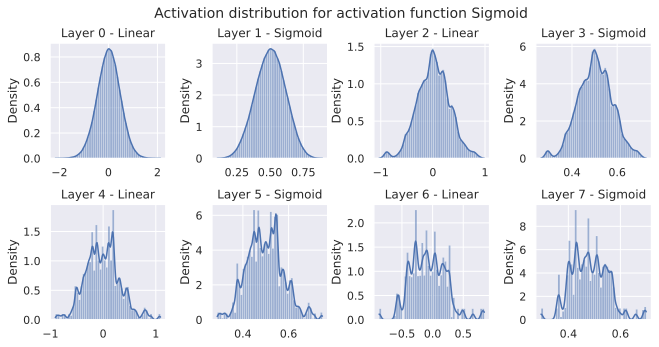

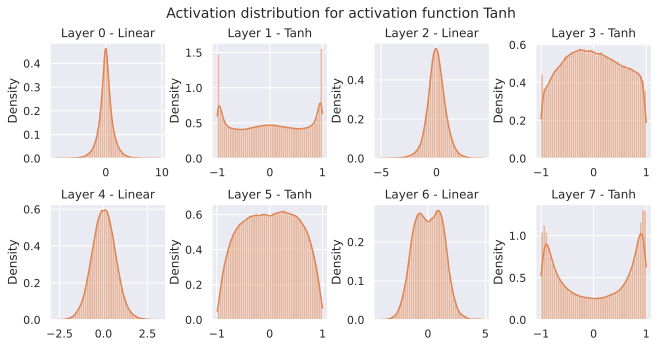

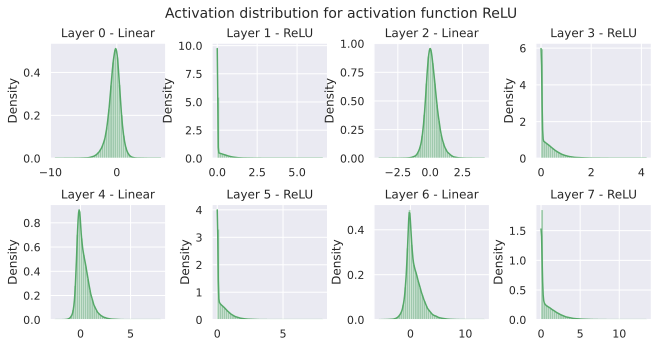

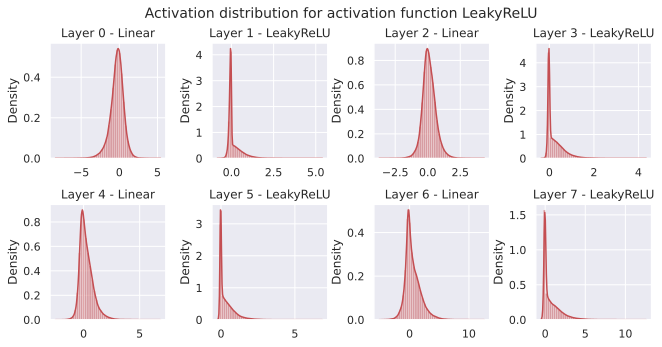

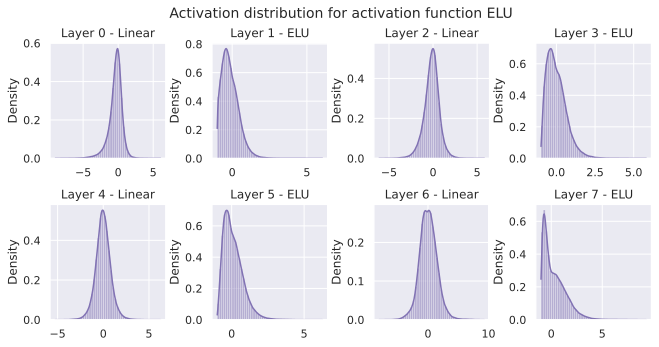

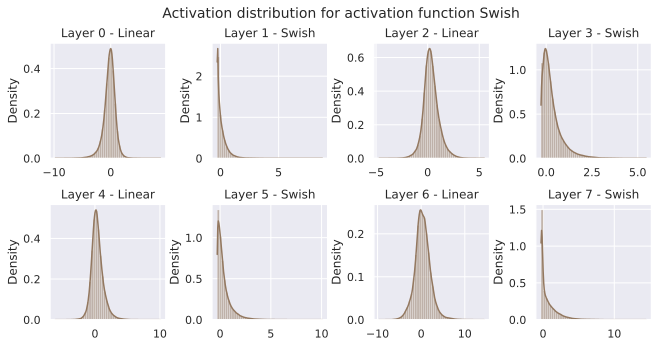

In [ ]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn, color=f"C{i}")

As the model with sigmoid activation failed to train properly, the activations are also less informative, clustering around 0.5 (activation at input 0).
Tanh exhibits a more diverse behavior. Although the input layer shows a higher concentration of neurons near -1 and 1, where gradients approach zero, the activations in the subsequent layers gravitate towards zero. This trend likely arises from the input layers seeking specific features in the input image, while subsequent layers amalgamate these features. Activations in the final layer tend toward extreme values again, as the classification layer can be viewed as a weighted average of these values (with gradients pushing activations to the extremes).
ReLU displays a pronounced peak at 0, as anticipated. The absence of gradients for negative values results in the network exhibiting a distribution with a longer tail toward positive values after the linear layers.

LeakyReLU demonstrates a very similar behavior to ReLU, while ELU exhibits a more Gaussian-like distribution.
Swish activation lies somewhere in between; however, it is noteworthy that Swish utilizes significantly higher values than other activation functions (up to 20).

Given the slight variations in behavior among the activation functions, despite achieving a similar performance in the simple network, it becomes evident that the selection of the "optimal" activation function depends on numerous factors and is not uniform across all possible networks.

##Finding dead neurons in ReLU networks

One known drawback of ReLU activation is the appearance of ``dead neurons'', referring to neurons without gradient for any training input.
The problem with dead neurons is that, without a gradient provided for the layer, it becomes impossible to train the parameters of this neuron in the preceding layer to generate output values other than zero.
To cause dead neurons to arise, the output value of a specific neuron in the linear layer before the ReLU must be negative for all input images.

Considering the large number of neurons present in a neural network, such occurrences are not uncommon. To gain a better understanding of the extent of this issue and when caution is warranted, the prevalence of dead neurons across different networks will be assessed. To accomplish this, a function will be developed to execute the network across the training set and record whether a neuron is exactly 0 for all data points.

In [ ]:
def measure_number_dead_neurons(net):

    # For each neuron, we create a Boolean variable initially set to 1. If it has an activation unequals 0 at any time,
    # we set this variable to 0. After running through the whole training set, only dead neurons will have a 1.
    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool) for layer in net.layers[:-1] if isinstance(layer, nn.Linear)
    ] # Same shapes as hidden size in BaseNetwork

    net.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(train_loader, leave=False): # Run through whole training set
            layer_index = 0
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0), -1)
            for layer in net.layers[:-1]:
                imgs = layer(imgs)
                if isinstance(layer, ActivationFunction):
                    # Are all activations == 0 in the batch, and we did not record the opposite in the last batches?
                    neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim=0))
                    layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print("In percentage:", ", ".join([f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))

Firstly, the number of dead neurons can be measured for an untrained network.

In [ ]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 3, 10]
In percentage: 0.00%, 0.00%, 1.17%, 7.81%


It is observed that there are only a small number of dead neurons, but their number increases with the depth of the layer. However, this is not problematic due to updates to the weights of previous layers, which change the input to later layers. Therefore, dead neurons in later layers have the potential to become "alive" or active again. What does this look like for a trained network (with the same initialization)?

In [ ]:
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 0, 3]
In percentage: 0.00%, 0.00%, 0.00%, 2.34%


The number of dead neurons indeed increased in the later layers. However, it should be noted that dead neurons are especially problematic in the input layer. As the input does not change over epochs (the training set is kept as is), training the network cannot activate those neurons again. However, the input data usually have a sufficiently high standard deviation to reduce the risk of dead neurons.

Finally, the behavior of the number of dead neurons with increasing layer depth is examined. For instance, investigating the neural network that comprises 10 layers:

In [ ]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU(), hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128]).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 7, 27, 89, 60, 58, 61, 72, 56]
In percentage: 0.00%, 0.00%, 2.73%, 10.55%, 34.77%, 46.88%, 45.31%, 47.66%, 56.25%, 43.75%


The number of dead neurons is significantly higher than before, which hampers gradient flow, especially in initial iterations. For instance, more than 56\% of the neurons in the pre-last layer are dead, creating a considerable bottleneck.

Therefore, it is advisable to use other nonlinearities like Swish for very deep networks.

##Conclusion

In this notebook, a set of six activation functions (sigmoid, tanh, ReLU, LeakyReLU, ELU, and Swish) in neural networks have been reviewed, discussing how they influence the gradient distribution across layers. Sigmoid tends to fail in deep neural networks, as it provides a maximum gradient of 0.25, leading to vanishing gradients in early layers. All ReLU-based activation functions have shown good performance and, unlike the original ReLU, do not suffer from the issue of dead neurons. When implementing a neural network, it is recommended to start with a ReLU-based network and select the specific activation function based on the properties of the network.